In [27]:
import pandas as pd

# Load the dataset
df = pd.read_csv("load_data.csv")

# Convert 'Date_Time' to datetime format
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%d-%m-%Y %H:%M', errors='coerce')

# Extract time-based features
df['Year'] = df['Date_Time'].dt.year
df['Month'] = df['Date_Time'].dt.month
df['Day'] = df['Date_Time'].dt.day
df['Hour'] = df['Date_Time'].dt.hour
df['Minute'] = df['Date_Time'].dt.minute

# Columns with missing values (numeric only)
num_cols_with_missing = [
    'Usage_kWh',
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'CO2(tCO2)',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor',
    'NSM'
]

# Impute missing values with median
for col in num_cols_with_missing:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)
print(df.head())



            Date_Time  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0 2018-01-01 00:15:00   8.753692                                  2.95   
1 2018-01-01 00:30:00   4.000000                                  4.46   
2 2018-01-01 00:45:00   3.240000                                  3.28   
3 2018-01-01 01:00:00   3.310000                                  3.56   
4 2018-01-01 01:15:00   3.820000                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor          NSM  \
0                     73.210000                         100.0   900.000000   
1                     66.770000                         100.0  1800.000000

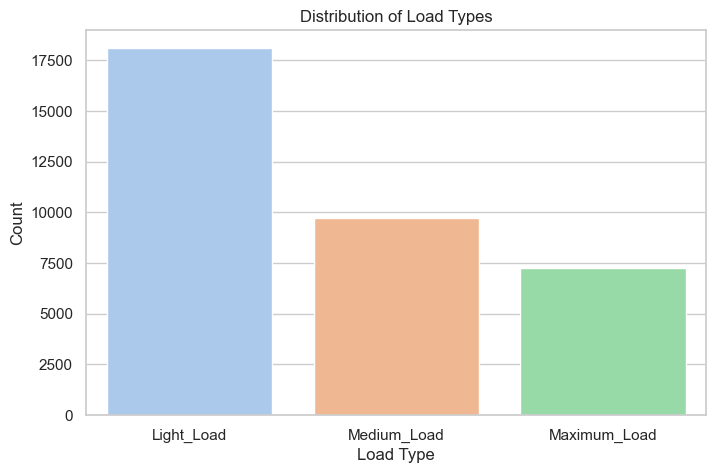

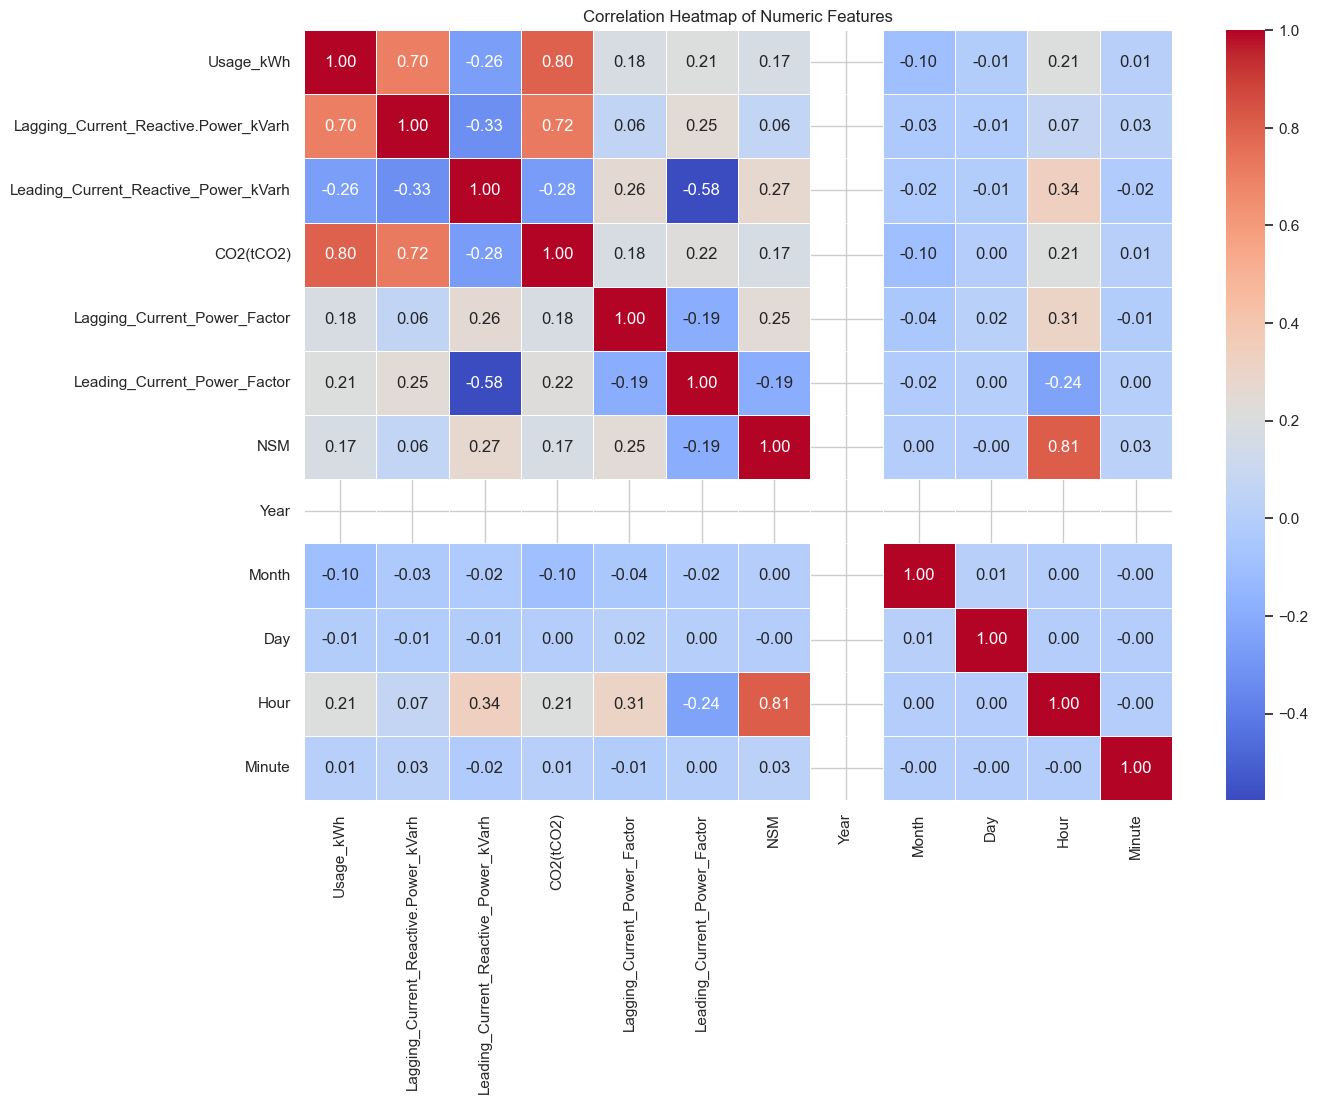

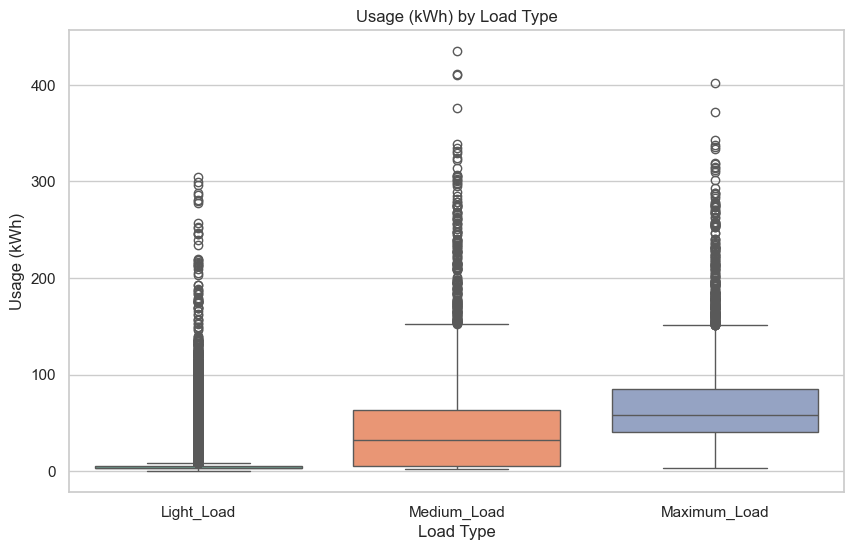

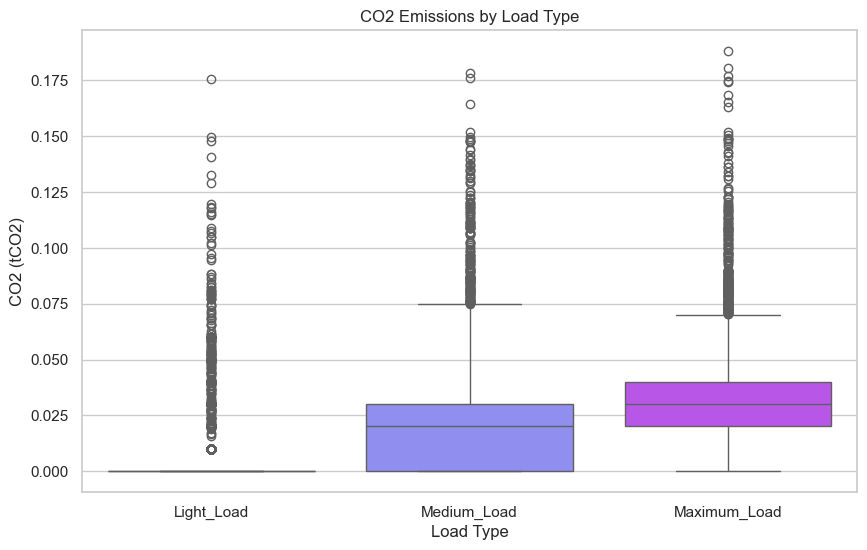

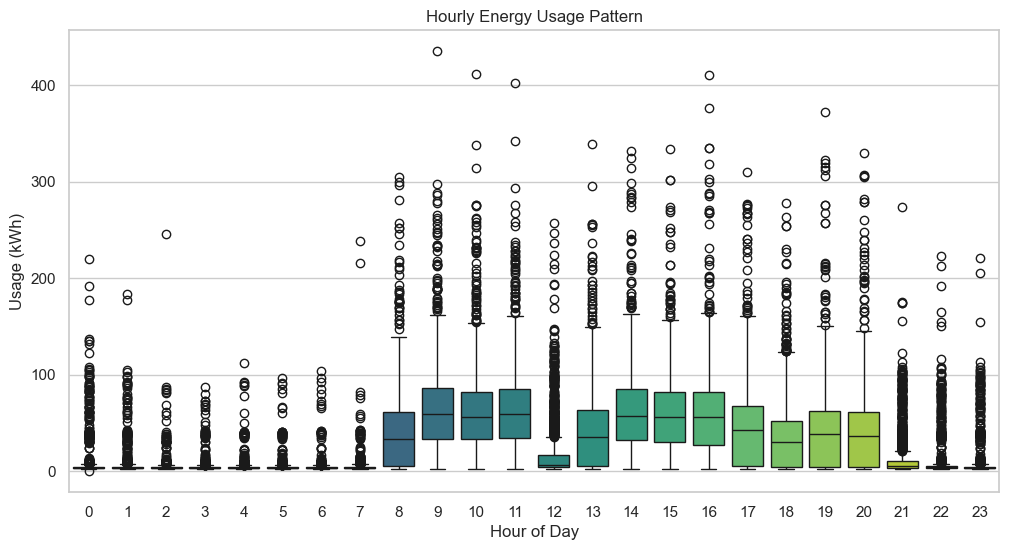

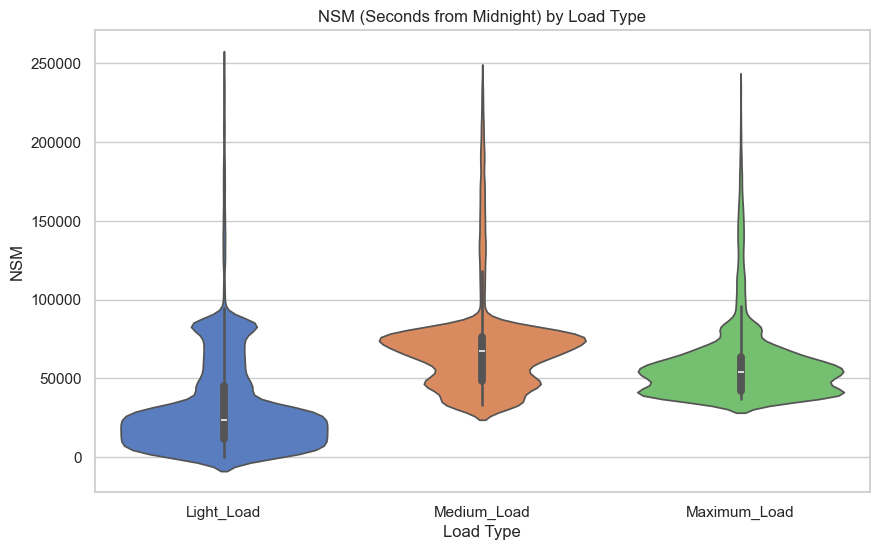

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1. Load Type Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Load_Type', hue='Load_Type', data=df, palette='pastel', legend=False)
plt.title("Distribution of Load Types")
plt.xlabel("Load Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(14, 10))
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# 3. Usage_kWh by Load Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Load_Type', y='Usage_kWh', hue='Load_Type', data=df, palette='Set2', legend=False)
plt.title("Usage (kWh) by Load Type")
plt.xlabel("Load Type")
plt.ylabel("Usage (kWh)")
plt.show()

# 4. CO2(tCO2) by Load Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='Load_Type', y='CO2(tCO2)', hue='Load_Type', data=df, palette='cool', legend=False)
plt.title("CO2 Emissions by Load Type")
plt.xlabel("Load Type")
plt.ylabel("CO2 (tCO2)")
plt.show()

# 5. Hourly Usage Pattern
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Usage_kWh', hue='Hour', data=df, palette='viridis', legend=False)
plt.title("Hourly Energy Usage Pattern")
plt.xlabel("Hour of Day")
plt.ylabel("Usage (kWh)")
plt.show()

# 6. NSM by Load Type
plt.figure(figsize=(10, 6))
sns.violinplot(x='Load_Type', y='NSM', hue='Load_Type', data=df, palette='muted', legend=False)
plt.title("NSM (Seconds from Midnight) by Load Type")
plt.xlabel("Load Type")
plt.ylabel("NSM")
plt.show()


In [29]:
# =============================
# 🧠 Feature Engineering Section
# =============================

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Use existing time-based features
df['Is_Peak_Hour'] = df['Hour'].apply(lambda x: 1 if 9 <= x <= 18 else 0)  # Working hours
df['Is_Weekend'] = pd.to_datetime(df['Date_Time']).dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# 2. Log transformation for skewed features (optional)
df['log_Usage_kWh'] = np.log1p(df['Usage_kWh'])
df['log_CO2'] = np.log1p(df['CO2(tCO2)'])

# 3. Final feature list
features = [
    'Usage_kWh',
    'Lagging_Current_Reactive.Power_kVarh',
    'Leading_Current_Reactive_Power_kVarh',
    'CO2(tCO2)',
    'Lagging_Current_Power_Factor',
    'Leading_Current_Power_Factor',
    'NSM',
    'Hour',
    'Month',
    'Is_Peak_Hour',
    'Is_Weekend',
    'log_Usage_kWh',
    'log_CO2'
]

# 4. Input and target variables
X = df[features]
y = df['Load_Type']

# 5. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 6. Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. DataFrame of scaled features (optional, for model inputs)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)


In [30]:
# ==============================
# ⏳ Time-Based Train-Test Split
# ==============================

# Identify the latest month and year in the dataset
latest_month = df['Date_Time'].dt.month.max()
latest_year = df[df['Date_Time'].dt.month == latest_month]['Date_Time'].dt.year.max()

# Filter test set: records from the latest month and year
test_df = df[(df['Date_Time'].dt.month == latest_month) & (df['Date_Time'].dt.year == latest_year)]

# Filter training set: all records before the latest month/year
train_df = df[~df.index.isin(test_df.index)]

# Create train-test feature and target arrays
X_train = train_df[features]
y_train = le.transform(train_df['Load_Type'])

X_test = test_df[features]
y_test = le.transform(test_df['Load_Type'])

# Scale features using existing scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check dataset sizes
print(" Train set shape:", X_train.shape)
print(" Test set shape:", X_test.shape)



 Train set shape: (32064, 13)
 Test set shape: (2977, 13)


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Store evaluation results
results = {}

# Training and Evaluation Loop
for name, model in models.items():
    print(f"\n Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print(f" {name} - Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    print(f" Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Store F1 score (macro avg) as a quick summary
    f1_macro = cross_val_score(model, X_train_scaled, y_train, scoring='f1_macro', cv=5).mean()
    results[name] = f1_macro

# Summary of macro F1-scores
print("\n Cross-Validated F1 Macro Scores:")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")



 Training Random Forest...
 Random Forest - Classification Report:
              precision    recall  f1-score   support

  Light_Load       0.99      0.90      0.94      1745
Maximum_Load       0.89      0.87      0.88       528
 Medium_Load       0.80      0.98      0.88       704

    accuracy                           0.92      2977
   macro avg       0.89      0.92      0.90      2977
weighted avg       0.92      0.92      0.92      2977

 Confusion Matrix:
[[1579   49  117]
 [  15  460   53]
 [   9    8  687]]

 Training Logistic Regression...
 Logistic Regression - Classification Report:
              precision    recall  f1-score   support

  Light_Load       0.97      0.79      0.88      1745
Maximum_Load       0.35      0.41      0.38       528
 Medium_Load       0.33      0.43      0.37       704

    accuracy                           0.64      2977
   macro avg       0.55      0.55      0.54      2977
weighted avg       0.71      0.64      0.67      2977

 Confusion Matri

 Classification Report:
              precision    recall  f1-score   support

  Light_Load       0.97      0.79      0.88      1745
Maximum_Load       0.35      0.41      0.38       528
 Medium_Load       0.33      0.43      0.37       704

    accuracy                           0.64      2977
   macro avg       0.55      0.55      0.54      2977
weighted avg       0.71      0.64      0.67      2977

 Evaluation Metrics:
 Accuracy:  0.6423
 Precision: 0.5519
 Recall:    0.5481
 F1 Score:  0.5436


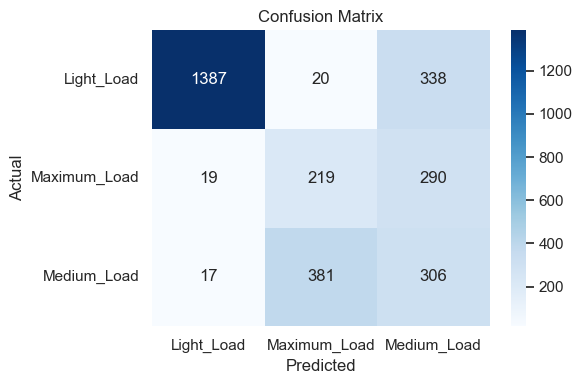

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure prediction is available
y_pred = model.predict(X_test_scaled)  # model = best performing model (e.g., RandomForest)

# 1. Text Summary Metrics
print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 2. Individual Metric Scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(" Evaluation Metrics:")
print(f" Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1 Score:  {f1:.4f}")

# 3. Confusion Matrix Visualization
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


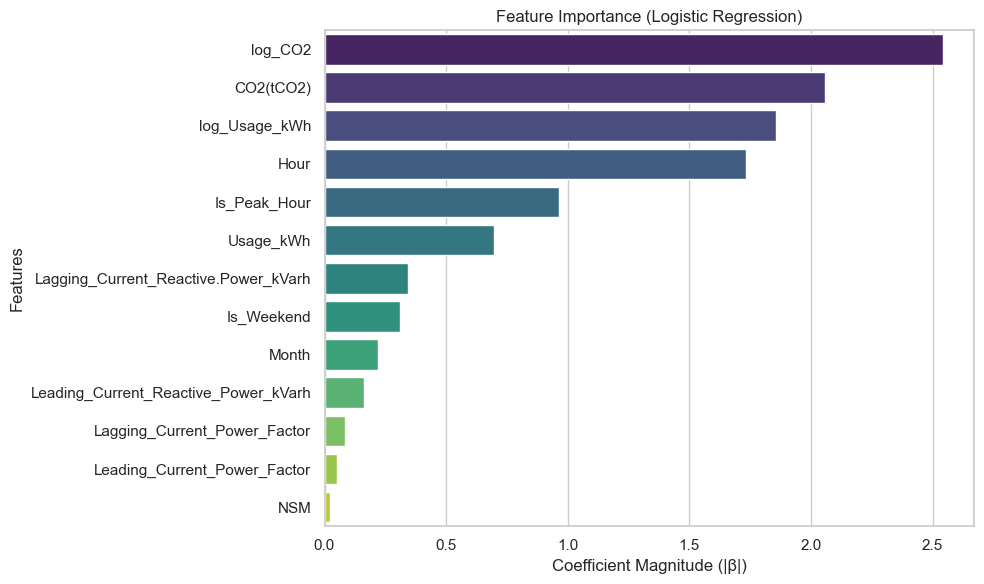

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'model' is your trained model (RandomForest or LogisticRegression)
# and 'features' is your list of feature names

# Check model type and extract importance
if hasattr(model, 'feature_importances_'):
    # Tree-based model (e.g., Random Forest)
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    xlabel = 'Relative Importance'
    title = 'Feature Importance (Tree-Based Model)'

elif hasattr(model, 'coef_'):
    # Linear model (e.g., Logistic Regression)
    coefficients = model.coef_[0]
    importances = np.abs(coefficients)
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    xlabel = 'Coefficient Magnitude (|β|)'
    title = 'Feature Importance (Logistic Regression)'

else:
    raise ValueError("The provided model does not support feature importance extraction.")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=importance_df, palette='viridis', legend=False)
plt.title(f'{title}')
plt.xlabel(xlabel)
plt.ylabel('Features')
plt.tight_layout()
plt.show()



 Training and Evaluating Random Forest...

 Classification Report:
              precision    recall  f1-score   support

  Light_Load       0.99      0.90      0.94      1745
Maximum_Load       0.89      0.87      0.88       528
 Medium_Load       0.80      0.98      0.88       704

    accuracy                           0.92      2977
   macro avg       0.89      0.92      0.90      2977
weighted avg       0.92      0.92      0.92      2977


 Training and Evaluating Logistic Regression...

 Classification Report:
              precision    recall  f1-score   support

  Light_Load       0.97      0.79      0.88      1745
Maximum_Load       0.35      0.41      0.38       528
 Medium_Load       0.33      0.43      0.37       704

    accuracy                           0.64      2977
   macro avg       0.55      0.55      0.54      2977
weighted avg       0.71      0.64      0.67      2977


 Summary of Evaluation Metrics:
                 Model  Accuracy  Precision    Recall  F1 Score

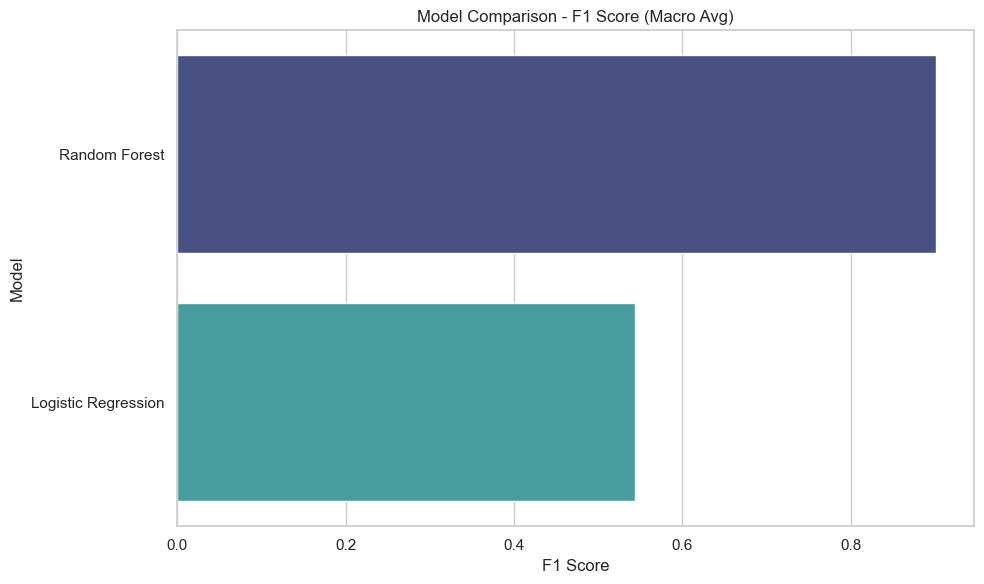

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define models to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # Optional: Uncomment if xgboost is installed
    # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Store evaluation results
results = []

for name, model in models.items():
    print(f"\n Training and Evaluating {name}...")

    # Train
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Store results
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

    # Optional: Display confusion matrix
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# Create DataFrame of results
results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print("\n Summary of Evaluation Metrics:")
print(results_df)

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='F1 Score', y='Model', hue='Model', data=results_df, palette='mako', legend=False)
plt.title('Model Comparison - F1 Score (Macro Avg)')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()
